In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
from dipy.sims.voxel import multi_tensor, multi_tensor_odf
from dipy.data import get_data, get_sphere
from dipy.core.gradients import gradient_table
from dipy.reconst.dsi import DiffusionSpectrumModel
from dipy.viz import fvtk

import json
from diGP.preprocessing import get_HCP_loader, get_SPARC_loader
from diGP.dataManipulations import DataHandler
from diGP.model import GaussianProcessModel, get_default_independent_kernel
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
with open('../config.json', 'r') as json_file:
    conf = json.load(json_file)

In [4]:
dataset = 'SPARC'
if dataset == 'HCP':
    subject_path = conf['HCP']['data_paths']['mgh_1007']
    loader = get_HCP_loader(subject_path)
elif dataset == 'SPARC':
    subject_path = conf['SPARC']['data_paths']['gradient_30']
    loader = get_SPARC_loader(subject_path)

In [5]:
gtab = {}
data = {}
odf = {}

In [6]:
gtab['train'] = loader.gtab
gtab['train'].info

B-values shape (91,)
         min 0.000000 
         max 3000.000000 
B-vectors shape (91, 3)
         min -0.983059 
         max 0.940868 


For the testing we will use a standard DSI acqusition scheme with 514 gradient directions and 1 S0. There's also the alternative of having a scheme with 4195 directions. In the case of the simulated multi-tensor signal is doesn't seem to make a big difference.

In [7]:
btable = np.loadtxt(get_data('dsi515btable'))
#btable = np.loadtxt(get_data('dsi4169btable'))

gtab['test'] = gradient_table(btable[:, 0], btable[:, 1:],
                              big_delta=gtab['train'].big_delta, small_delta=gtab['train'].small_delta)
gtab['test'].info

B-values shape (515,)
         min 0.000000 
         max 11538.500000 
B-vectors shape (515, 3)
         min -1.000000 
         max 1.000000 


Let’s create a multi tensor with 2 fiber directions at 60 degrees.

In [8]:
evals = np.array([[0.0015, 0.0003, 0.0003],
                  [0.0015, 0.0003, 0.0003]])

directions = [(-30, 0), (30, 0)]

fractions = [50, 50]

for key, _gtab in gtab.items():
    data[key] = multi_tensor(_gtab, evals, 100, angles=directions,
                             fractions=fractions, snr=None)[0][None, None, None, :]

In [9]:
sphere = get_sphere('symmetric724').subdivide(1)

odf['gt'] = multi_tensor_odf(sphere.vertices, evals, angles=directions,
                             fractions=fractions)[None, None, None, :]

Perform the reconstructions with standard DSI. To get sharp results, having a large r_end seems to have the biggest impact but increasing the qgrid_size also has some effect. Also, you can effectively disable the Hanning filter by setting the filter_width to infinity.

In [10]:
dsi_model = DiffusionSpectrumModel(gtab['test'], qgrid_size=25, r_end=50, filter_width=np.inf)
dsi_fit = dsi_model.fit(data['test'])

odf['dsi'] = dsi_fit.odf(sphere)

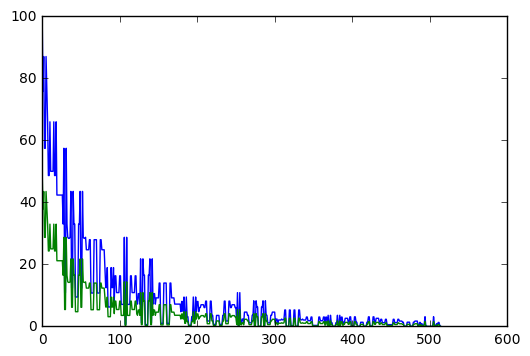

In [11]:
#dsi_model.filter
#plt.plot(gtab['train'].qvals)
plt.plot(data['test'].flatten())
#plt.plot(data['pred'].flatten())
plt.plot(dsi_fit.data.flatten() * dsi_model.filter)

In [12]:
dsi_fit.rtop_pdf(normalized=False)/dsi_fit.rtop_signal(filtering=True)
#/dsi_model.fit(data['pred']).rtop_signal(filtering=True)

array([[[ 1.]]])

Predict the test data values using GP. To save time the hyperparameters are set to the values that the training would otherwise yield.

In [13]:
if dataset == 'HCP':
    kernel = get_default_independent_kernel(3, n_max=6, q_lengthscale=1.16, coefficients=(1778, 31.4, 3.63, 0.56))

    gp_model = GaussianProcessModel(gtab['train'], kernel=kernel)
    gp_fit = gp_model.fit(data['train'], retrain=False)
elif dataset == 'SPARC':
    kernel = get_default_independent_kernel(3, n_max=6, q_lengthscale=0.57, coefficients=(2578, 52, 5.0, 0.94))

    gp_model = GaussianProcessModel(gtab['train'], kernel=kernel, verbose=False)
    gp_fit = gp_model.fit(data['train'], retrain=False)

 C:\Users\sesjojen\AppData\Local\Continuum\Anaconda3\lib\site-packages\paramz\transformations.py:109: RuntimeWarning:overflow encountered in expm1


In [14]:
odf['gp'] = gp_fit.odf(sphere)

Visualize the ground truth ODF together with the DSI.

In [15]:
ren = fvtk.ren()

odfs = np.vstack((odf['gt'], odf['dsi'], odf['gp']))

odf_actor = fvtk.sphere_funcs(odfs, sphere)
odf_actor.RotateX(90)
fvtk.add(ren, odf_actor)
fvtk.record(ren, out_path='dsi_sim.png', size=(300, 300))